## Procedimiento Estándar de Clustering (Kaggle)

# I. Análisis de clientes de un Centro Comercial

### Modificado de E. Inzaugarat

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
import seaborn as sns
%matplotlib inline

In [6]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio

In [7]:
# import extra_graphs

## DataSet del Centro Comercial

In [14]:
customers = pd.read_csv("Mall_Customers.csv")
customers.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Mall_Customers.csv'

In [12]:
customers

NameError: name 'customers' is not defined

k-means no permite datos nulos, por lo que hay que localizar estos ejemplos y decidir su tratamiento (si son pocos, generalmente se eliminan). En este caso, no hay variables con datos faltantes.

In [10]:
print(f"Datos perdidos en cada variable: \n{customers.isnull().sum()}")

NameError: name 'customers' is not defined

k-means solo admite variables en una escala de rango o de proporción, ya que se basa en distancias entre los ejemplos. Si se requiere considerar variables categóricas hay que transformarlas.

In [ ]:
print(f"Variables:                Tipo: \n{customers.dtypes}")

El género (Gender) es categórica y se procede a su transformación, haciendo 0 a Male y 1 a Femane.

## Exploración de datos: estadística descriptiva

In [11]:
def statistics(variable):
    if variable.dtype == "int64" or variable.dtype == "float64":
        return pd.DataFrame([[variable.name, np.mean(variable), np.std(variable), np.median(variable), np.var(variable)]], 
                            columns = ["Variable", "Mean", "Standard Deviation", "Median", "Variance"]).set_index("Variable")
    else:
        return pd.DataFrame(variable.value_counts())

In [12]:
def histplot(x):
    if x.dtype == "int64" or x.dtype == "float64":
        # Select size of bins by getting maximum and minimum and divide the substraction by 10
        size_bins = 10
        # Get the title by getting the name of the column
        title = x.name
        #Assign random colors to each graph
        color_kde = list(map(float, np.random.rand(3,)))
        color_bar = list(map(float, np.random.rand(3,)))

        # Plot the displot
        sns.distplot(x, bins=size_bins, kde_kws={"lw": 1.5, "alpha":0.8, "color":color_kde},
                       hist_kws={"linewidth": 1.5, "edgecolor": "grey",
                                "alpha": 0.4, "color":color_bar})
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.ylabel("Frecuencia", size=16, labelpad=15);
        # Customize title
        plt.title(title, size=18)
        # Customize grid and axes visibility
        plt.grid(False);
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);   
    else:
        x = pd.DataFrame(x)
        # Plot       
        sns.catplot(x=x.columns[0], kind="count", palette="spring", data=x)
        # Customize title
        title = x.columns[0]
        plt.title(title, size=18)
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.xlabel("")
        plt.ylabel("Counts", size=16, labelpad=15);        
        # Customize grid and axes visibility
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);

In [13]:
spending = customers["Spending Score (1-100)"]
# incomme = customers["Annual Income (k$)"]

In [14]:
statistics(spending)
# statistics(age)
# statistics(incomme)

Mean  Standard Deviation  Median  Variance
Variable                                                          
Spending Score (1-100)  50.2           25.758882    50.0    663.52

/Users/josel/opt/anaconda3/envs/python/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



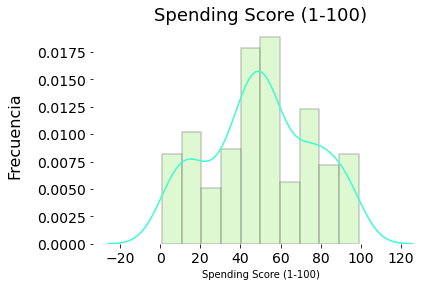

In [15]:
histplot(spending)

In [16]:
age = customers["Age"]

In [17]:
statistics(age)

Mean  Standard Deviation  Median  Variance
Variable                                             
Age       38.85           13.934041    36.0  194.1575

/Users/josel/opt/anaconda3/envs/python/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



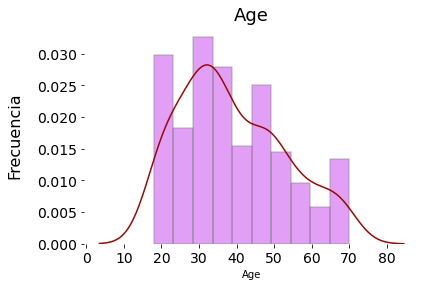

In [18]:
histplot(age)

In [19]:
income = customers["Annual Income (k$)"]

In [20]:
statistics(income)

Mean  Standard Deviation  Median  Variance
Variable                                                       
Annual Income (k$)  60.56           26.198977    61.5  686.3864

/Users/josel/opt/anaconda3/envs/python/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



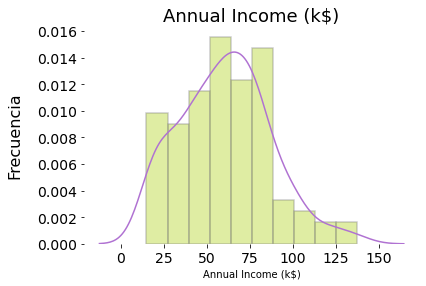

In [21]:
histplot(income)

In [22]:
gender = customers["Gender"]

In [23]:
statistics(gender)

Gender
Female     112
Male        88

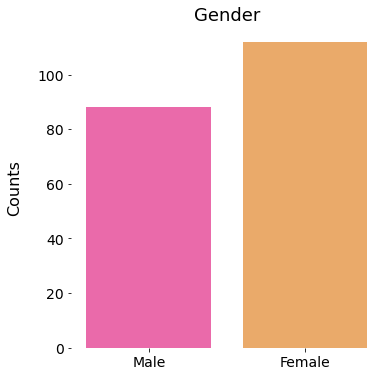

In [24]:
histplot(gender)

### Correlaciones

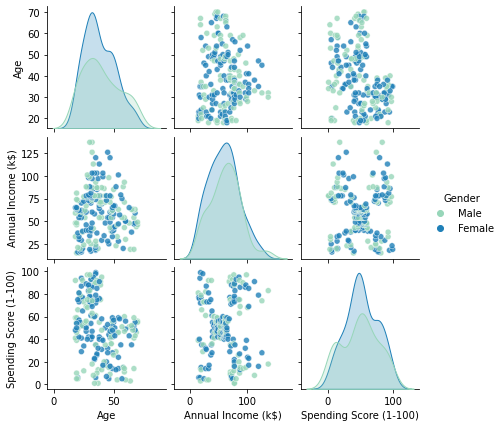

In [25]:
sns.pairplot(customers, x_vars = ["Age", "Annual Income (k$)", "Spending Score (1-100)"], 
               y_vars = ["Age", "Annual Income (k$)", "Spending Score (1-100)"], 
               hue = "Gender", 
               kind= "scatter",
               palette = "YlGnBu",
               height = 2,
               plot_kws={"s": 35, "alpha": 0.8});

## Reducción de dimensiones con PCA (proceso de ordenación)

In [26]:
customers["Male"] = customers.Gender.apply(lambda x: 0 if x == "Male" else 1)

In [27]:
customers["Female"] = customers.Gender.apply(lambda x: 0 if x == "Female" else 1)

In [28]:
X = customers.iloc[:, 2:]

In [29]:
X.head()

Age  Annual Income (k$)  Spending Score (1-100)  Male  Female
0   19                  15                      39     0       1
1   21                  15                      81     0       1
2   20                  16                       6     1       0
3   23                  16                      77     1       0
4   31                  17                      40     1       0

In [30]:
# Apply PCA and fit the features selected
pca = PCA(n_components=2).fit(X)

In [31]:
print(pca.components_)

[[-1.88980385e-01  5.88604475e-01  7.86022241e-01  3.32880772e-04
  -3.32880772e-04]
 [ 1.30957602e-01  8.08400899e-01 -5.73875514e-01 -1.57927017e-03
   1.57927017e-03]]


In [32]:
print(pca.explained_variance_)

[700.26450987 684.33354753]


In [33]:
# Transform samples using the PCA fit
pca_2d = pca.transform(X)

In [34]:
# def biplot(score, coeff, labels=None):
#    xs = score[:,0]
#    ys = score[:,1]
#    n = coeff.shape[0]
#    scalex = 1.0/(xs.max()- xs.min())
#    scaley = 1.0/(ys.max()- ys.min())
#    plt.scatter(xs*scalex,ys*scaley, color="#c7e9c0", edgecolor="#006d2c", alpha=0.5)
#    for i in range(n):
#        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color='#253494',alpha=0.5,lw=2) 
#        if labels is None:
#            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color="#000000", ha="center", va="center")
#        else:
#            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color="#000000", ha="center", va="center")
#    plt.xlim(-.75,1)
#    plt.ylim(-0.5,1)
#    plt.grid(False)
#    plt.xticks(np.arange(0, 1, 0.5), size=12)
#    plt.yticks(np.arange(-0.75, 1, 0.5), size=12)
#    plt.xlabel("Componente 1", size=14)
#    plt.ylabel("Componente 2", size=14)
#    plt.gca().spines["top"].set_visible(False);
#    plt.gca().spines["right"].set_visible(False);

In [35]:
# Biplot

def biplot(score, coeff, labels=X.columns):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley, color="#c7e9c0", edgecolor="#006d2c", alpha=0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color='#253494',alpha=0.5,lw=2) 
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color="#000000", ha="center", va="center")
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color="#000000", ha="center", va="center")
    plt.xlim(-.75,1)
    plt.ylim(-0.5,1)
    plt.grid(False)
    plt.xticks(np.arange(0, 1, 0.5), size=12)
    plt.yticks(np.arange(-0.75, 1, 0.5), size=12)
    plt.xlabel("Componente 1", size=14)
    plt.ylabel("Componente 2", size=14)
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);  

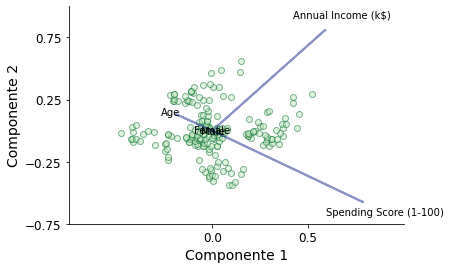

In [36]:
biplot(pca_2d[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [37]:
# extra_graphs.biplot(pca_2d[:,0:2], np.transpose(pca.components_[0:2, :]), labels=X.columns)

# Análisis de clustering

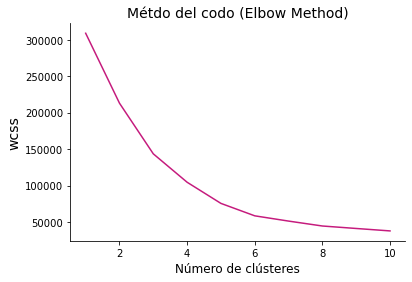

In [38]:
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Métdo del codo (Elbow Method)', size=14)
plt.xlabel('Número de clústeres', size=12)
plt.ylabel('wcss', size=14)
plt.show()

In [39]:
# Kmeans algorithm
# n_clusters: Number of clusters. In our case 5
# init: k-means++. Smart initialization
# max_iter: Maximum number of iterations of the k-means algorithm for a single run
# n_init: Number of time the k-means algorithm will be run with different centroid seeds. 
# random_state: Determines random number generation for centroid initialization.
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=10, n_init=10, random_state=0)

# Fit and predict 
y_means = kmeans.fit_predict(X)

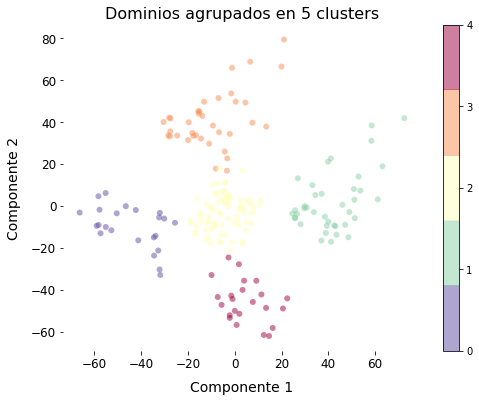

In [40]:
fig, ax = plt.subplots(figsize = (8, 6))

plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
            c=y_means, 
            edgecolor="none", 
            cmap=plt.cm.get_cmap("Spectral_r", 5),
            alpha=0.5)
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("Componente 1", size = 14, labelpad=10)
plt.ylabel("Componente 2", size = 14, labelpad=10)

plt.title('Dominios agrupados en 5 clusters', size=16)


plt.colorbar(ticks=[0, 1, 2, 3, 4]);

plt.show()

In [41]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ["Age", "Annual Income", "Spending", "Male", "Female"])

In [42]:
centroids.index_name = "ClusterID"

In [43]:
centroids["ClusterID"] = centroids.index
centroids = centroids.reset_index(drop=True)

### Si la cantidad de datos es muy grande, k-means consumirá mucho tiempo de cómputo; pero es posible diseñar estrategias de muestreo para encontrar centroides con pocos datos y clasificar los históricos y los nuevos.

In [44]:
centroids

Age  Annual Income   Spending      Male    Female  ClusterID
0  45.217391      26.304348  20.913043  0.608696  0.391304          0
1  32.692308      86.538462  82.128205  0.538462  0.461538          1
2  43.088608      55.291139  49.569620  0.582278  0.417722          2
3  40.666667      87.750000  17.583333  0.472222  0.527778          3
4  25.521739      26.304348  78.565217  0.608696  0.391304          4

In [2]:
X_new = np.array([[48, 76, 20, 0, 1]]) 
 
new_customer = kmeans.predict(X_new)
print(f"El nuevo cliente pertecene al segmento {new_customer[0]}")

NameError: name 'np' is not defined

# II. Perfilado de cursos

### Comercio electrónico - Modificado de V. Patil

In [46]:
import pandas as pd
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as ss
from sklearn.preprocessing import MinMaxScaler

In [48]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [49]:
def show_null_count(df):
    df_null = pd.DataFrame(data=df.isnull().sum(),columns=['nulls'])
    df_null = df_null.sort_values('nulls', ascending=False)
    return df_null

In [50]:
df_sales = pd.read_csv('./data/clustering_sales.csv')
df_customer = pd.read_csv('./data/clustering_customer.csv')
df_product = pd.read_csv('./data/clustering_product.csv')
df_payment = pd.read_csv('./data/clustering_payment.csv')

In [51]:
df_sales.head()

order_id  order_item_id     tran_dt  customer_id  dollars  qty  product_id  \
0         1              1  2020-01-01          572      550    1          20   
1         2              2  2020-01-01          532      630    3          11   
2         3              3  2020-01-01          608      450    2          18   
3         4              4  2020-01-01          424      110    2          10   
4         5              5  2020-01-01          584      250    1           8   

   payment_type_id  
0                2  
1                2  
2                4  
3                2  
4                4

### Los datos están organizados por orden, por lo que se encontrarán muchos cursos (cursos_id). Es necesario convertir las entradas de eventos a un dataset de partes que pueda ser usado para un clustering.

In [52]:
(df_sales.shape, df_sales.order_item_id.nunique(), df_sales.order_id.nunique())

((10000, 8), 10000, 9811)

In [53]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   order_id         10000 non-null  int64 
 1   order_item_id    10000 non-null  int64 
 2   tran_dt          10000 non-null  object
 3   customer_id      10000 non-null  int64 
 4   dollars          10000 non-null  int64 
 5   qty              10000 non-null  int64 
 6   product_id       10000 non-null  int64 
 7   payment_type_id  10000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 625.1+ KB


In [54]:
df_customer.head()

customer_id  age  hh_income  omni_shopper  email_subscribed
0            1   46     640000             0                 0
1            2   32     890000             1                 1
2            3   45     772000             0                 0
3            4   46     303000             0                 1
4            5   38     412000             0                 0

In [55]:
(df_sales.customer_id.nunique(), df_customer.shape, df_customer.customer_id.nunique())

(1000, (1000, 5), 1000)

In [56]:
df_product.head()

product_id category  price
0           1        A    450
1           2        B     80
2           3        C    250
3           4        D    400
4           5        E     50

In [57]:
(df_product.shape, df_product.product_id.nunique())

((22, 3), 22)

In [58]:
df_payment.head()

payment_type_id payment_type
0                1         cash
1                2  credit card
2                3   debit card
3                4    gift card
4                5       others

Los datos con los que se cuenta son de una año calendario para el 2020 y conformarán en su totalidad, un timeFrame.

In [59]:
df_sales = df_sales.merge(df_product[['product_id','category']], on=['product_id'])
df_sales = df_sales.merge(df_payment, on=['payment_type_id'])

In [60]:
df_features_overall = df_sales.groupby(['customer_id']).agg({
    'dollars':'sum',
    'qty':'sum',
    'order_id':'nunique',
    'product_id':'nunique',
    'payment_type_id':'nunique',
    'category':'nunique'
    })

In [61]:
df_features_overall['aov'] = df_features_overall['dollars']/df_features_overall['order_id']
df_features_overall['aur'] = df_features_overall['dollars']/df_features_overall['qty']
df_features_overall['upt'] = df_features_overall['qty']/df_features_overall['order_id']

In [62]:
df_features_overall.columns = [
    'sales','units','orders','unique_products_bought','unique_payments_used',
    'unique_categories_bought','aov','aur','upt']

In [63]:
df_features_overall.head()

sales  units  orders  unique_products_bought  \
customer_id                                                 
1             2395     11       5                       5   
2             4815     15       7                       6   
3             4285     21      10                       9   
4            12000     44      21                      15   
5             1700      8       3                       3   

             unique_payments_used  unique_categories_bought         aov  \
customer_id                                                               
1                               3                         3  479.000000   
2                               4                         3  687.857143   
3                               4                         5  428.500000   
4                               4                         5  571.428571   
5                               2                         2  566.666667   

                    aur       upt  
customer_id                        
1            217.727273  2.200000  
2            321.000000  2.142857  
3            204.047619  2.100000  
4            272.727273  2.095238  
5            212.500000  2.666667

## Métricas para comercio electrónico: tasa de conversión, valor promedio de las órdenes (aov = total ingresado/número de chackouts), ... y unidates promedio por ticket (upt)

In [64]:
df_category_features_s = df_sales.groupby(['customer_id','category']).agg({'dollars':'sum'}).reset_index()

In [65]:
df_category_features_s = df_category_features_s.merge(df_features_overall[['sales']], on=['customer_id'])

In [66]:
df_category_features_s['sales_perc'] = df_category_features_s['dollars']/df_category_features_s['sales']

In [67]:
df_category_features_s.head()

customer_id category  dollars  sales  sales_perc
0            1        A     1150   2395    0.480167
1            1        C     1080   2395    0.450939
2            1        E      165   2395    0.068894
3            2        A     3475   4815    0.721703
4            2        C     1190   4815    0.247144

In [68]:
df_category_features_s = df_category_features_s.pivot(index='customer_id', columns='category', values='sales_perc')
df_category_features_s.columns = [
    'category_a_sales','category_b_sales','category_c_sales','category_d_sales','category_e_sales']

In [69]:
df_category_features_s.head()

category_a_sales  category_b_sales  category_c_sales  \
customer_id                                                         
1                    0.480167               NaN          0.450939   
2                    0.721703               NaN          0.247144   
3                    0.240373          0.175029          0.309218   
4                    0.575000          0.067500          0.158333   
5                         NaN          0.264706          0.735294   

             category_d_sales  category_e_sales  
customer_id                                      
1                         NaN          0.068894  
2                         NaN          0.031153  
3                    0.210035          0.065344  
4                    0.170833          0.028333  
5                         NaN               NaN

In [70]:
df_category_features_u = df_sales.groupby(['customer_id','category']).agg({'qty':'sum'}).reset_index()

In [71]:
df_category_features_u = df_category_features_u.merge(df_features_overall[['units']], on=['customer_id'])

In [72]:
df_category_features_u['units_perc'] = df_category_features_u['qty']/df_category_features_u['units']

In [73]:
df_category_features_u.head()

customer_id category  qty  units  units_perc
0            1        A    4     11    0.363636
1            1        C    4     11    0.363636
2            1        E    3     11    0.272727
3            2        A    7     15    0.466667
4            2        C    5     15    0.333333

In [74]:
df_category_features_u = df_category_features_u.pivot(index='customer_id', columns='category', values='units_perc')
df_category_features_u.columns = [
    'category_a_units','category_b_units','category_c_units','category_d_units','category_e_units']

In [75]:
df_category_features_u.head()

category_a_units  category_b_units  category_c_units  \
customer_id                                                         
1                    0.363636               NaN          0.363636   
2                    0.466667               NaN          0.333333   
3                    0.190476          0.238095          0.238095   
4                    0.409091          0.159091          0.181818   
5                         NaN          0.375000          0.625000   

             category_d_units  category_e_units  
customer_id                                      
1                         NaN          0.272727  
2                         NaN          0.200000  
3                    0.095238          0.238095  
4                    0.113636          0.136364  
5                         NaN               NaN

In [76]:
df_payment_features = df_sales.groupby(['customer_id','payment_type']).agg({'dollars':'sum'}).reset_index()

In [77]:
df_payment_features = df_payment_features.merge(df_features_overall[['sales']], on=['customer_id'])

In [78]:
df_payment_features['sales_perc'] = df_payment_features['dollars']/df_payment_features['sales']

In [79]:
df_payment_features.head()

customer_id payment_type  dollars  sales  sales_perc
0            1  credit card     1245   2395    0.519833
1            1   debit card      400   2395    0.167015
2            1    gift card      750   2395    0.313152
3            2         cash      150   4815    0.031153
4            2  credit card     3390   4815    0.704050

In [80]:
df_payment_features = df_payment_features.pivot(index='customer_id', columns='payment_type', values='sales_perc')
df_payment_features.columns = [
    'payment_cash','payment_credit','payment_debit','payment_gc','payment_others']

In [81]:
df_payment_features.head()

payment_cash  payment_credit  payment_debit  payment_gc  \
customer_id                                                            
1                     NaN        0.519833       0.167015    0.313152   
2                0.031153        0.704050       0.186916    0.077882   
3                     NaN        0.263711       0.309218    0.147025   
4                0.066667        0.345000       0.370000    0.218333   
5                     NaN             NaN       0.735294    0.264706   

             payment_others  
customer_id                  
1                       NaN  
2                       NaN  
3                  0.280047  
4                       NaN  
5                       NaN

In [82]:
df_features = df_features_overall.merge(df_category_features_s,on='customer_id',how='left')

df_features = df_features.merge(df_category_features_u,on='customer_id',how='left')

df_features = df_features.merge(df_payment_features,on='customer_id',how='left')

df_features = df_features.merge(
    df_customer[['customer_id','email_subscribed','omni_shopper']].set_index('customer_id'),
    on='customer_id',how='left')

In [83]:
df_features.head()

sales  units  orders  unique_products_bought  \
customer_id                                                 
1             2395     11       5                       5   
2             4815     15       7                       6   
3             4285     21      10                       9   
4            12000     44      21                      15   
5             1700      8       3                       3   

             unique_payments_used  unique_categories_bought         aov  \
customer_id                                                               
1                               3                         3  479.000000   
2                               4                         3  687.857143   
3                               4                         5  428.500000   
4                               4                         5  571.428571   
5                               2                         2  566.666667   

                    aur       upt  category_a_sales  category_b_sales  \
customer_id                                                             
1            217.727273  2.200000          0.480167               NaN   
2            321.000000  2.142857          0.721703               NaN   
3            204.047619  2.100000          0.240373          0.175029   
4            272.727273  2.095238          0.575000          0.067500   
5            212.500000  2.666667               NaN          0.264706   

             category_c_sales  category_d_sales  category_e_sales  \
customer_id                                                         
1                    0.450939               NaN          0.068894   
2                    0.247144               NaN          0.031153   
3                    0.309218          0.210035          0.065344   
4                    0.158333          0.170833          0.028333   
5                    0.735294               NaN               NaN   

             category_a_units  category_b_units  category_c_units  \
customer_id                                                         
1                    0.363636               NaN          0.363636   
2                    0.466667               NaN          0.333333   
3                    0.190476          0.238095          0.238095   
4                    0.409091          0.159091          0.181818   
5                         NaN          0.375000          0.625000   

             category_d_units  category_e_units  payment_cash  payment_credit  \
customer_id                                                                     
1                         NaN          0.272727           NaN        0.519833   
2                         NaN          0.200000      0.031153        0.704050   
3                    0.095238          0.238095           NaN        0.263711   
4                    0.113636          0.136364      0.066667        0.345000   
5                         NaN               NaN           NaN             NaN   

             payment_debit  payment_gc  payment_others  email_subscribed  \
customer_id                                                                
1                 0.167015    0.313152             NaN                 0   
2                 0.186916    0.077882             NaN                 1   
3                 0.309218    0.147025        0.280047                 0   
4                 0.370000    0.218333             NaN                 1   
5                 0.735294    0.264706             NaN                 0   

             omni_shopper  
customer_id                
1                       0  
2                       1  
3                       0  
4                       0  
5                       0

In [84]:
df_features.to_csv('./data/clustering_features.csv', index=True)

In [85]:
df_features.describe().T

count         mean          std         min  \
sales                     1000.0  5707.170000  4036.079859  330.000000   
units                     1000.0    21.108000    14.408398    3.000000   
orders                    1000.0     9.811000     6.384986    3.000000   
unique_products_bought    1000.0     7.547000     3.850535    2.000000   
unique_payments_used      1000.0     3.005000     0.948617    1.000000   
unique_categories_bought  1000.0     3.843000     1.014584    1.000000   
aov                       1000.0   575.336384   165.741267  110.000000   
aur                       1000.0   271.150530    65.941495   60.000000   
upt                       1000.0     2.124689     0.344007    1.000000   
category_a_sales           911.0     0.465008     0.200729    0.040698   
category_b_sales           754.0     0.129013     0.109362    0.005324   
category_c_sales           829.0     0.275343     0.169208    0.021024   
category_d_sales           678.0     0.317048     0.173845    0.033003   
category_e_sales           671.0     0.053478     0.064436    0.003299   
category_a_units           911.0     0.351488     0.173091    0.043478   
category_b_units           754.0     0.241836     0.134064    0.023256   
category_c_units           829.0     0.271817     0.149078    0.022727   
category_d_units           678.0     0.200435     0.126031    0.019608   
category_e_units           671.0     0.203009     0.131912    0.019608   
payment_cash               263.0     0.128239     0.126068    0.003754   
payment_credit             981.0     0.552566     0.211687    0.031339   
payment_debit              871.0     0.307976     0.183177    0.008929   
payment_gc                 634.0     0.202083     0.160023    0.007018   
payment_others             256.0     0.108743     0.102174    0.003154   
email_subscribed          1000.0     0.624000     0.484622    0.000000   
omni_shopper              1000.0     0.249000     0.432650    0.000000   

                                  25%          50%          75%           max  
sales                     2827.500000  4280.000000  7267.500000  17635.000000  
units                       11.000000    16.000000    23.000000     58.000000  
orders                       5.000000     8.000000    10.000000     24.000000  
unique_products_bought       5.000000     6.000000     9.000000     18.000000  
unique_payments_used         2.000000     3.000000     4.000000      5.000000  
unique_categories_bought     3.000000     4.000000     5.000000      5.000000  
aov                        467.500000   568.444444   670.238095   1202.500000  
aur                        227.836538   268.178138   311.271777    485.000000  
upt                          1.900000     2.139610     2.333333      3.666667  
category_a_sales             0.316973     0.459397     0.598472      1.000000  
category_b_sales             0.059289     0.103094     0.166667      1.000000  
category_c_sales             0.154321     0.244739     0.352052      0.951860  
category_d_sales             0.183344     0.281823     0.422400      0.940171  
category_e_sales             0.022009     0.037415     0.062500      0.809524  
category_a_units             0.226415     0.333333     0.454545      1.000000  
category_b_units             0.142857     0.218452     0.312500      1.000000  
category_c_units             0.166667     0.250000     0.333333      0.857143  
category_d_units             0.105263     0.168699     0.266667      0.727273  
category_e_units             0.111111     0.166667     0.263158      0.888889  
payment_cash                 0.038977     0.095969     0.168276      0.947867  
payment_credit               0.411765     0.544426     0.702323      1.000000  
payment_debit                0.172142     0.277212     0.406788      1.000000  
payment_gc                   0.081417     0.157143     0.275592      0.968661  
payment_others               0.041317     0.080988     0.144144      0.605042  
email_subscribed            

In [86]:
show_null_count(df_features)

nulls
payment_others              744
payment_cash                737
payment_gc                  366
category_e_sales            329
category_e_units            329
category_d_sales            322
category_d_units            322
category_b_sales            246
category_b_units            246
category_c_units            171
category_c_sales            171
payment_debit               129
category_a_sales             89
category_a_units             89
payment_credit               19
email_subscribed              0
sales                         0
units                         0
upt                           0
aur                           0
aov                           0
unique_categories_bought      0
unique_payments_used          0
unique_products_bought        0
orders                        0
omni_shopper                  0

In [87]:
df_features = df_features.fillna(0)

In [88]:
df_features.isnull().sum().sum()

0

In [89]:
df_clust = df_features.copy()

In [90]:
cols_scale = [
    'sales','units','upt','aur','aov','unique_categories_bought','unique_payments_used',
    'unique_products_bought','orders']

In [91]:
scaler = MinMaxScaler().fit(df_clust[cols_scale])
df_clust[cols_scale] = scaler.transform(df_clust[cols_scale])

print(df_clust.shape)
df_clust.head()

(1000, 26)


sales     units    orders  unique_products_bought  \
customer_id                                                         
1            0.119330  0.145455  0.095238                  0.1875   
2            0.259174  0.218182  0.190476                  0.2500   
3            0.228547  0.327273  0.333333                  0.4375   
4            0.674372  0.745455  0.857143                  0.8125   
5            0.079168  0.090909  0.000000                  0.0625   

             unique_payments_used  unique_categories_bought       aov  \
customer_id                                                             
1                            0.50                      0.50  0.337757   
2                            0.75                      0.50  0.528931   
3                            0.75                      1.00  0.291533   
4                            0.75                      1.00  0.422360   
5                            0.25                      0.25  0.418002   

                  aur       upt  category_a_sales  category_b_sales  \
customer_id                                                           
1            0.371123  0.450000          0.480167          0.000000   
2            0.614118  0.428571          0.721703          0.000000   
3            0.338936  0.412500          0.240373          0.175029   
4            0.500535  0.410714          0.575000          0.067500   
5            0.358824  0.625000          0.000000          0.264706   

             category_c_sales  category_d_sales  category_e_sales  \
customer_id                                                         
1                    0.450939          0.000000          0.068894   
2                    0.247144          0.000000          0.031153   
3                    0.309218          0.210035          0.065344   
4                    0.158333          0.170833          0.028333   
5                    0.735294          0.000000          0.000000   

             category_a_units  category_b_units  category_c_units  \
customer_id                                                         
1                    0.363636          0.000000          0.363636   
2                    0.466667          0.000000          0.333333   
3                    0.190476          0.238095          0.238095   
4                    0.409091          0.159091          0.181818   
5                    0.000000          0.375000          0.625000   

             category_d_units  category_e_units  payment_cash  payment_credit  \
customer_id                                                                     
1                    0.000000          0.272727      0.000000        0.519833   
2                    0.000000          0.200000      0.031153        0.704050   
3                    0.095238          0.238095      0.000000        0.263711   
4                    0.113636          0.136364      0.066667        0.345000   
5                    0.000000          0.000000      0.000000        0.000000   

             payment_debit  payment_gc  payment_others  email_subscribed  \
customer_id                                                                
1                 0.167015    0.313152        0.000000                 0   
2                 0.186916    0.077882        0.000000                 1   
3                 0.309218    0.147025        0.280047                 0   
4                 0.370000    0.218333        0.000000                 1   
5                 0.735294    0.264706        0.000000                 0   

             omni_shopper  
customer_id                
1                       0  
2                       1  
3                       0  
4                       0  
5                       0

In [92]:
pkl_filename = "./files/model_objects/kmeans_scaler_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(scaler, file)

In [93]:
df_clust.describe().T

count      mean       std  min       25%       50%  \
sales                     1000.0  0.310729  0.233232  0.0  0.144322  0.228258   
units                     1000.0  0.329236  0.261971  0.0  0.145455  0.236364   
orders                    1000.0  0.324333  0.304047  0.0  0.095238  0.238095   
unique_products_bought    1000.0  0.346687  0.240658  0.0  0.187500  0.250000   
unique_payments_used      1000.0  0.501250  0.237154  0.0  0.250000  0.500000   
unique_categories_bought  1000.0  0.710750  0.253646  0.0  0.500000  0.750000   
aov                       1000.0  0.425937  0.151708  0.0  0.327231  0.419629   
aur                       1000.0  0.496825  0.155156  0.0  0.394910  0.489831   
upt                       1000.0  0.421759  0.129003  0.0  0.337500  0.427354   
category_a_sales          1000.0  0.423622  0.232920  0.0  0.270173  0.428711   
category_b_sales          1000.0  0.097276  0.110024  0.0  0.015163  0.074244   
category_c_sales          1000.0  0.228259  0.185711  0.0  0.092650  0.205285   
category_d_sales          1000.0  0.214959  0.206029  0.0  0.000000  0.188518   
category_e_sales          1000.0  0.035884  0.058451  0.0  0.000000  0.022222   
category_a_units          1000.0  0.320206  0.193179  0.0  0.187500  0.310728   
category_b_units          1000.0  0.182344  0.156225  0.0  0.044960  0.166667   
category_c_units          1000.0  0.225336  0.170013  0.0  0.100000  0.207940   
category_d_units          1000.0  0.135895  0.139798  0.0  0.000000  0.106763   
category_e_units          1000.0  0.136219  0.144143  0.0  0.000000  0.112374   
payment_cash              1000.0  0.033727  0.085784  0.0  0.000000  0.000000   
payment_credit            1000.0  0.542067  0.222836  0.0  0.403791  0.539482   
payment_debit             1000.0  0.268247  0.199722  0.0  0.123380  0.247137   
payment_gc                1000.0  0.128121  0.160347  0.0  0.000000  0.072838   
payment_others            1000.0  0.027838  0.070137  0.0  0.000000  0.000000   
email_subscribed          1000.0  0.624000  0.484622  0.0  0.000000  1.000000   
omni_shopper              1000.0  0.249000  0.432650  0.0  0.000000  0.000000   

                               75%       max  
sales                     0.400896  1.000000  
units                     0.363636  1.000000  
orders                    0.333333  1.000000  
unique_products_bought    0.437500  1.000000  
unique_payments_used      0.750000  1.000000  
unique_categories_bought  1.000000  1.000000  
aov                       0.512804  1.000000  
aur                       0.591228  1.000000  
upt                       0.500000  1.000000  
category_a_sales          0.585021  1.000000  
category_b_sales          0.140781  1.000000  
category_c_sales          0.326688  0.951860  
category_d_sales          0.350588  0.940171  
category_e_sales          0.046804  0.809524  
category_a_units          0.437500  1.000000  
category_b_units          0.277778  1.000000  
category_c_units          0.326629  0.857143  
category_d_units          0.208576  0.727273  
category_e_units          0.208576  0.888889  
payment_cash              0.010809  0.947867  
payment_credit            0.693278  1.000000  
payment_debit             0.383302  1.000000  
payment_gc                0.198798  0.968661  
payment_others            0.008834  0.605042  
email_subscribed          1.000000  1.000000  
omni_shopper              0.000000  1.000000

In [94]:
k1 = []
sscore1 = []
inertia_s1 = []

for i in tqdm(range(2,21)):
    k1.append(i)
    kmeans1 = KMeans(n_clusters=i,random_state=125,max_iter=100).fit(df_clust)
    # print('k-means done')
    sscore1.append(ss(df_clust,kmeans1.labels_))
    # print('ss score done')
    inertia_s1.append(kmeans1.inertia_)
    # print('inertia done')
    # print('---')

100%|██████████| 19/19 [00:05<00:00,  3.31it/s]


Text(0, 0.5, 'Inertia score (SSE)')

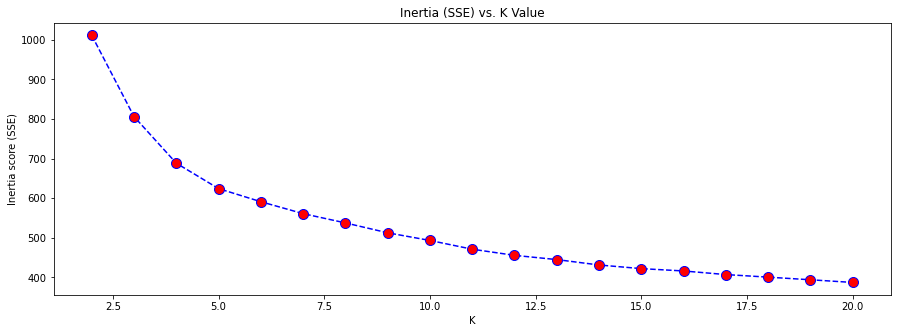

In [95]:
plt.figure(figsize=(15,5))
plt.plot(k1,inertia_s1,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Inertia (SSE) vs. K Value')
plt.xlabel('K')
plt.ylabel('Inertia score (SSE)')

Text(0, 0.5, 'SS')

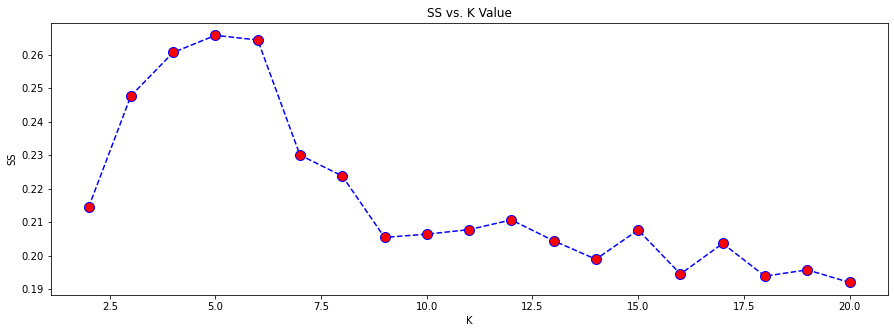

In [96]:
plt.figure(figsize=(15,5))
plt.plot(k1,sscore1,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('SS vs. K Value')
plt.xlabel('K')
plt.ylabel('SS')

In [97]:
kmeans = KMeans(n_clusters=6,random_state=125,max_iter=100).fit(df_clust)
sscore = ss(df_clust,kmeans.labels_)
inertia= kmeans.inertia_

print('sscore',sscore)
print('inertia',inertia)

sscore 0.2644425716291346
inertia 591.0601380602852


In [98]:
# save k-means
pkl_filename = "./files/model_objects/kmeans_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(kmeans, file)

In [99]:
df_features['cluster_ids'] = kmeans.labels_

In [100]:
df_features = df_features.merge(
    df_customer[['customer_id','age','hh_income']].set_index('customer_id'),
    on='customer_id',how='left')
df_features = df_features.reset_index()

In [101]:
df_profile_overall = df_features.describe().T

# use median for age and hh_income
df_profile_overall['Overall Dataset'] = df_profile_overall.apply(
    lambda row: row['50%']   if row.name in ['age','hh_income'] else
    row['count'] if row.name in ['customer_id'] else row['mean'],
    axis=1)
df_profile_overall = df_profile_overall[['Overall Dataset']]

In [102]:
df_cluster_summary = df_features.groupby('cluster_ids').describe().T.reset_index()
df_cluster_summary = df_cluster_summary.rename(columns={'level_0':'column','level_1':'metric'})

In [103]:
# keep median for age & hh_income, count for customer id
df_cluster_summary = df_cluster_summary.query(
    '''
        (column.isin(["age","hh_income"]) & metric == "50%") | \
        (column.isin(["customer_id"]) & metric == "count") | \
        (~column.isin(["customer_id","age","hh_income"]) & metric == "mean")
    ''',
    engine='python')

In [104]:
df_cluster_summary['Metric'] = df_cluster_summary.apply(
    lambda row: 'median' if row['metric']=='50%' else row['metric'],
    axis=1)
df_cluster_summary = df_cluster_summary.set_index('column')
df_cluster_summary = df_cluster_summary.drop('metric', axis=1)

In [105]:
df_profile = df_cluster_summary.join(df_profile_overall) # joins on Index

# Ver Excel kmeans_profiling

In [106]:
df_profile.to_csv('./files/kmeans_profiling.csv')

In [107]:
df = pd.read_csv('./data/clustering_features.csv').set_index('customer_id')

In [108]:
df.head()

sales  units  orders  unique_products_bought  \
customer_id                                                 
1             2395     11       5                       5   
2             4815     15       7                       6   
3             4285     21      10                       9   
4            12000     44      21                      15   
5             1700      8       3                       3   

             unique_payments_used  unique_categories_bought         aov  \
customer_id                                                               
1                               3                         3  479.000000   
2                               4                         3  687.857143   
3                               4                         5  428.500000   
4                               4                         5  571.428571   
5                               2                         2  566.666667   

                    aur       upt  category_a_sales  category_b_sales  \
customer_id                                                             
1            217.727273  2.200000          0.480167               NaN   
2            321.000000  2.142857          0.721703               NaN   
3            204.047619  2.100000          0.240373          0.175029   
4            272.727273  2.095238          0.575000          0.067500   
5            212.500000  2.666667               NaN          0.264706   

             category_c_sales  category_d_sales  category_e_sales  \
customer_id                                                         
1                    0.450939               NaN          0.068894   
2                    0.247144               NaN          0.031153   
3                    0.309218          0.210035          0.065344   
4                    0.158333          0.170833          0.028333   
5                    0.735294               NaN               NaN   

             category_a_units  category_b_units  category_c_units  \
customer_id                                                         
1                    0.363636               NaN          0.363636   
2                    0.466667               NaN          0.333333   
3                    0.190476          0.238095          0.238095   
4                    0.409091          0.159091          0.181818   
5                         NaN          0.375000          0.625000   

             category_d_units  category_e_units  payment_cash  payment_credit  \
customer_id                                                                     
1                         NaN          0.272727           NaN        0.519833   
2                         NaN          0.200000      0.031153        0.704050   
3                    0.095238          0.238095           NaN        0.263711   
4                    0.113636          0.136364      0.066667        0.345000   
5                         NaN               NaN           NaN             NaN   

             payment_debit  payment_gc  payment_others  email_subscribed  \
customer_id                                                                
1                 0.167015    0.313152             NaN                 0   
2                 0.186916    0.077882             NaN                 1   
3                 0.309218    0.147025        0.280047                 0   
4                 0.370000    0.218333             NaN                 1   
5                 0.735294    0.264706             NaN                 0   

             omni_shopper  
customer_id                
1                       0  
2                       1  
3                       0  
4                       0  
5                       0

In [109]:
# fill na
df = df.fillna(0)

# scaling
cols_scale = [
    'sales','units','upt','aur','aov','unique_categories_bought','unique_payments_used',
    'unique_products_bought','orders']

# Load scaler  from file
pkl_filename = "./files/model_objects/kmeans_scaler_model.pkl"
with open(pkl_filename, 'rb') as file:
    scaler = pickle.load(file)

df[cols_scale] = scaler.transform(df[cols_scale])

# Load k-means from file
pkl_filename = "./files/model_objects/kmeans_model.pkl"
with open(pkl_filename, 'rb') as file:
    kmeans = pickle.load(file)

df['cluster_ids'] = kmeans.predict(df)

# save labels
df[['cluster_ids']].to_csv('./files/kmeans_labels.csv', index=True)

In [110]:
df.cluster_ids.value_counts()

0    293
4    284
2    194
1     92
5     82
3     55
Name: cluster_ids, dtype: int64